<a href="https://colab.research.google.com/github/yylonly/ServeNet/blob/stacked-bert/ServeNet/BERT_TF2_Keras_TPU_GoogleDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
!nvidia-smi

TensorFlow 2.x selected.
Mon Dec  2 11:47:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                   

In [0]:
#@title Hyberparameters:
batch_size = 64 #@param {type:"integer"}
maxLen = 110 #@param {type:"integer"}
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1" #@param ["https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"]

if bert_path == "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1":
  hiddenSize = 768
elif bert_path == "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1":
  hiddenSize = 1024

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.0.0
Hub version:  0.7.0


In [0]:
SavePrefix='BERT-TF2-Keras-TPU-GoolgeDrive'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

if os.path.isdir("/content/drive/My Drive/ServeNet"):
  os.chdir("/content/drive/My Drive/ServeNet")
else: 
  !git clone https://github.com/yylonly/ServeNet.git
  os.chdir("/content/drive/My Drive/ServeNet")

In [0]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  # tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Detect hardware
# tf.keras.backend.clear_session()

# for compatible tensorflow 2.0
# tf.compat.v1.disable_eager_execution()

# resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)

Running on single GPU  /job:localhost/replica:0/task:0/device:GPU:0
Number of accelerators:  1


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import h5py
import pandas as pd
import numpy as np

#from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.initializers import Orthogonal

In [0]:
h5f = h5py.File('Data/BERT-ServiceDataset-New.h5','r') 
X_train = h5f['train_input_ids'][:8064].astype(np.int32)
X_mask_train = h5f['train_input_masks'][:8064].astype(np.int32)
X_segment_train = h5f['train_segment_ids'][:8064].astype(np.int32)
Y_train = h5f['Train_Y_one_hot'][:8064].astype(np.int32)

X_test = h5f['test_input_ids'][:2048].astype(np.int32)
X_mask_test = h5f['test_input_masks'][:2048].astype(np.int32)
X_segment_test = h5f['test_segment_ids'][:2048].astype(np.int32)
Y_test = h5f['Test_Y_one_hot'][:2048].astype(np.int32)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

step = len(X_train) // batch_size

(8064, 110) (8064, 50)
(2048, 110) (2048, 50)


In [0]:
def ServeNet(input_shape):
    """
    Function creating the ServeNet model
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # INPUT
    in_id = Input(shape=input_shape, dtype=tf.int32, name="input_word_ids")
    in_mask = Input(shape=input_shape, dtype=tf.int32, name="input_masks")
    in_segment = Input(shape=input_shape, dtype=tf.int32, name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    # BERT
    bert_layer = hub.KerasLayer(bert_path, trainable=True, name="bert")
    _, sequence_output = bert_layer(bert_inputs)
    embeddings = Reshape((maxLen, hiddenSize, 1))(sequence_output)
    
    # CNN
    features1 = Conv2D(32, kernel_size=(3, 3), padding='same')(embeddings)
    features1 = Dropout(0.1)(features1)
    features2 = Conv2D(1, kernel_size=(1, 1), padding='same')(features1)
    # features2 = Dropout(0.4)(features2)

    features = Reshape((maxLen, hiddenSize))(features2)
     
    # LSTM
    X = Bidirectional(LSTM(512, return_sequences=False))(features)
    X = Dropout(0.1)(X)

    # TASK 
    # X = Dense(200, activation='tanh', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(X)
    # X = Dropout(0.1)(X)
    X = Dense(50, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=bert_inputs, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
checkpointer = ModelCheckpoint(filepath='Data/ServeNet-' + SavePrefix + '.hdf5', monitor='val_top_k_categorical_accuracy', verbose=1, save_best_only=True)

In [0]:
adam = tf.keras.optimizers.Adam(lr=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay=0.01)
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8, nesterov=True)

In [0]:
with strategy.scope():
    model = ServeNet((maxLen, ))
    model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=[metrics.top_k_categorical_accuracy, metrics.categorical_accuracy])

In [0]:
for layer in model.layers:
    print(layer.output_shape)
model.summary()

[(None, 110)]
[(None, 110)]
[(None, 110)]
[(None, 768), (None, None, 768)]
(None, 110, 768, 1)
(None, 110, 768, 32)
(None, 110, 768, 32)
(None, 110, 768, 1)
(None, 110, 768)
(None, 1024)
(None, 1024)
(None, 50)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 110)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 110)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 110)]        0                                            
_________________________________________________________________________________

In [0]:
history = model.fit([X_train, X_mask_train, X_segment_train], Y_train, validation_data=([X_test, X_mask_test, X_segment_test],  Y_test), epochs=20, steps_per_epoch=step, verbose = 1, callbacks=[checkpointer])

Train on 8064 samples, validate on 2048 samples
Epoch 1/20
8000/8064 [============================>.] - ETA: 0s - loss: 3.7968 - top_k_categorical_accuracy: 0.2549 - categorical_accuracy: 0.0821
Epoch 00001: val_top_k_categorical_accuracy improved from -inf to 0.30176, saving model to Data/ServeNet-BERT-TF2-Keras-TPU-GoolgeDrive.hdf5
8064/8064 [==============================] - 138s 17ms/sample - loss: 3.7936 - top_k_categorical_accuracy: 0.2561 - categorical_accuracy: 0.0828 - val_loss: 3.5646 - val_top_k_categorical_accuracy: 0.3018 - val_categorical_accuracy: 0.1401
Epoch 2/20
8000/8064 [============================>.] - ETA: 0s - loss: 2.8692 - top_k_categorical_accuracy: 0.6166 - categorical_accuracy: 0.3458
Epoch 00002: val_top_k_categorical_accuracy improved from 0.30176 to 0.78906, saving model to Data/ServeNet-BERT-TF2-Keras-TPU-GoolgeDrive.hdf5
8064/8064 [==============================] - 115s 14ms/sample - loss: 2.8633 - top_k_categorical_accuracy: 0.6179 - categorical_accur

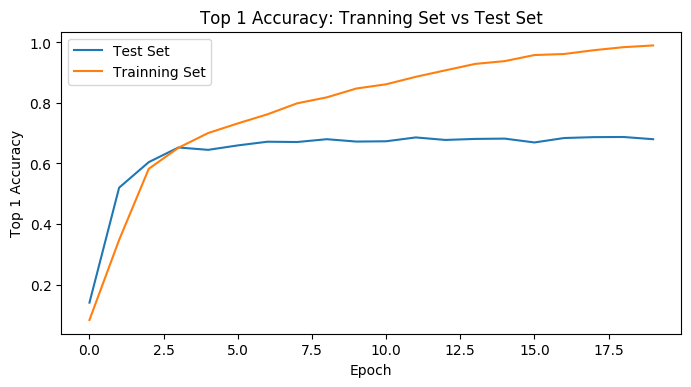

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + 'ServeNetTop1.pdf', format='pdf', dpi=300)

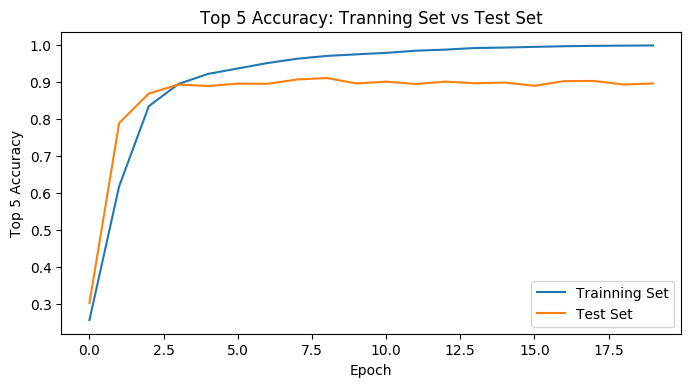

<Figure size 432x288 with 0 Axes>

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetTop5.pdf', format='pdf', dpi=300)

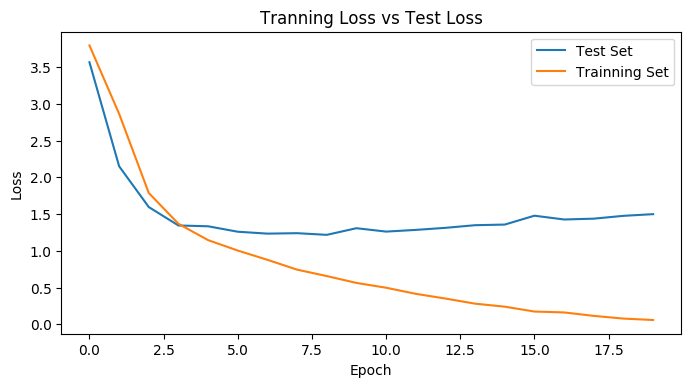

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetLoss.pdf', format='pdf', dpi=300)

In [0]:
import pickle
  
f = open(SavePrefix + '-ServeNetHistory', 'wb')
pickle.dump(history.history, f)
f.close()

In [0]:
import pickle

f = open(SavePrefix + '-ServeNetHistory', 'rb')
his = pickle.load(f)
f.close()

In [0]:
val_top_k = his['val_top_k_categorical_accuracy']
print("top5: ", max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print("loss: ", min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print("top1: ", max(val_ca))
print(np.argmax(val_ca))

top5:  0.9111328
8
loss:  1.216956466436386
8
top1:  0.6875
18


In [0]:
model = load_model('Data/ServeNet-' + SavePrefix + '.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
print("Training set:")
loss_train, top5error_train, top1error_train = model.evaluate([X_train, X_mask_train, X_segment_train], Y_train)
print("Top5 Training accuracy = ", top5error_train)
print("Top1 Training accuracy = ", top1error_train)
print('Test set:')
loss_test, top5error_test, top1error_test = model.evaluate([X_test, X_mask_test, X_segment_test], Y_test)
print("Training accuracy = ", top5error_test)
print("Top1 Training accuracy = ", top1error_test)

Training set:
8064/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict([X_test, X_mask_test, X_segment_test])

In [0]:
print(predY_test.shape)
print(Y_test.shape)

(2048, 50)
(2048, 50)


In [0]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

In [0]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Advertising',
 'Analytics',
 'Application Development',
 'Backend',
 'Banking',
 'Bitcoin',
 'Chat',
 'Cloud',
 'Data',
 'Database',
 'Domains',
 'Education',
 'Email',
 'Enterprise',
 'Entertainment',
 'Events',
 'File Sharing',
 'Financial',
 'Games',
 'Government',
 'Images',
 'Internet of Things',
 'Mapping',
 'Marketing',
 'Media',
 'Medical',
 'Messaging',
 'Music',
 'News Services',
 'Other',
 'Payments',
 'Photos',
 'Project Management',
 'Real Estate',
 'Reference',
 'Science',
 'Search',
 'Security',
 'Shipping',
 'Social',
 'Sports',
 'Stocks',
 'Storage',
 'Telephony',
 'Tools',
 'Transportation',
 'Travel',
 'Video',
 'Weather',
 'eCommerce', "All"]

In [0]:
# If predict top5 includes true value, set true value to pred_test set
non_onehot_Y_test = np.argmax(Y_test, axis=1)
non_onehot_pred_test = np.zeros((non_onehot_Y_test.shape))
non_onehot_pred_test_top5 = np.argsort(predY_test, axis=-1)[:, -5:][:, ::-1]

m = non_onehot_Y_test.shape[0]

for i in range(0, m):
    if non_onehot_Y_test[i] in non_onehot_pred_test_top5[i]:
        non_onehot_pred_test[i] = non_onehot_Y_test[i]


In [0]:
non_onehot_Y_test.shape

(2048,)

In [0]:
non_onehot_pred_test.shape

(2048,)

In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [0]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Advertising,Analytics,Application Development,Backend,Banking,Bitcoin,Chat,Cloud,Data,Database,Domains,Education,Email,Enterprise,Entertainment,Events,File Sharing,Financial,Games,Government,Images,Internet of Things,Mapping,Marketing,Media,Medical,Messaging,Music,News Services,Other,Payments,Photos,Project Management,Real Estate,Reference,Science,Search,Security,Shipping,Social,Sports,Stocks,Storage,Telephony,Tools,Transportation,Travel,Video,Weather,eCommerce,All
Actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Advertising,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42
Analytics,8,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27
Application Development,3,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
Backend,5,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41
Banking,4,0,0,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56


In [0]:
cross.columns

Index(['Advertising', 'Analytics', 'Application Development', 'Backend',
       'Banking', 'Bitcoin', 'Chat', 'Cloud', 'Data', 'Database', 'Domains',
       'Education', 'Email', 'Enterprise', 'Entertainment', 'Events',
       'File Sharing', 'Financial', 'Games', 'Government', 'Images',
       'Internet of Things', 'Mapping', 'Marketing', 'Media', 'Medical',
       'Messaging', 'Music', 'News Services', 'Other', 'Payments', 'Photos',
       'Project Management', 'Real Estate', 'Reference', 'Science', 'Search',
       'Security', 'Shipping', 'Social', 'Sports', 'Stocks', 'Storage',
       'Telephony', 'Tools', 'Transportation', 'Travel', 'Video', 'Weather',
       'eCommerce', 'All'],
      dtype='object', name='Predicted')

In [0]:
all = cross["All"]

In [0]:
result = []

all = cross["All"]

for i in range(0, 50):
    acc = cross.iloc[i,i] / all[i]
    result.append(acc)

In [0]:
result

[1.0,
 0.7037037037037037,
 0.8125,
 0.8780487804878049,
 0.9285714285714286,
 0.95,
 0.926829268292683,
 0.8947368421052632,
 0.9615384615384616,
 0.9285714285714286,
 0.8795180722891566,
 1.0,
 0.9583333333333334,
 1.0,
 0.972972972972973,
 0.5789473684210527,
 0.6521739130434783,
 0.9375,
 0.6521739130434783,
 0.875,
 0.8214285714285714,
 0.8125,
 0.9565217391304348,
 0.9375,
 0.5357142857142857,
 0.8947368421052632,
 0.8857142857142857,
 0.9529411764705882,
 0.9761904761904762,
 0.9523809523809523,
 0.6923076923076923,
 0.8723404255319149,
 1.0,
 0.9583333333333334,
 1.0,
 0.9636363636363636,
 0.9240506329113924,
 0.9850746268656716,
 0.9487179487179487,
 0.9574468085106383,
 0.9032258064516129,
 0.8125,
 0.9523809523809523,
 0.9545454545454546,
 0.9767441860465116,
 0.9111111111111111,
 0.6666666666666666,
 0.9769230769230769,
 0.7586206896551724,
 0.9]

In [0]:
np.std(result)

0.11496042140327613

In [0]:
acc_category = dict(zip(categories, result)) 

import json
with open('Data/top5_servenet_new_acc_category.json', 'w') as fp:
    json.dump(acc_category, fp)


fp.close()

In [0]:
acc_category

{'Advertising': 1.0,
 'Analytics': 0.7037037037037037,
 'Application Development': 0.8125,
 'Backend': 0.8780487804878049,
 'Banking': 0.9285714285714286,
 'Bitcoin': 0.95,
 'Chat': 0.926829268292683,
 'Cloud': 0.8947368421052632,
 'Data': 0.9615384615384616,
 'Database': 0.9285714285714286,
 'Domains': 0.8795180722891566,
 'Education': 1.0,
 'Email': 0.9583333333333334,
 'Enterprise': 1.0,
 'Entertainment': 0.972972972972973,
 'Events': 0.5789473684210527,
 'File Sharing': 0.6521739130434783,
 'Financial': 0.9375,
 'Games': 0.6521739130434783,
 'Government': 0.875,
 'Images': 0.8214285714285714,
 'Internet of Things': 0.8125,
 'Mapping': 0.9565217391304348,
 'Marketing': 0.9375,
 'Media': 0.5357142857142857,
 'Medical': 0.8947368421052632,
 'Messaging': 0.8857142857142857,
 'Music': 0.9529411764705882,
 'News Services': 0.9761904761904762,
 'Other': 0.9523809523809523,
 'Payments': 0.6923076923076923,
 'Photos': 0.8723404255319149,
 'Project Management': 1.0,
 'Real Estate': 0.9583333

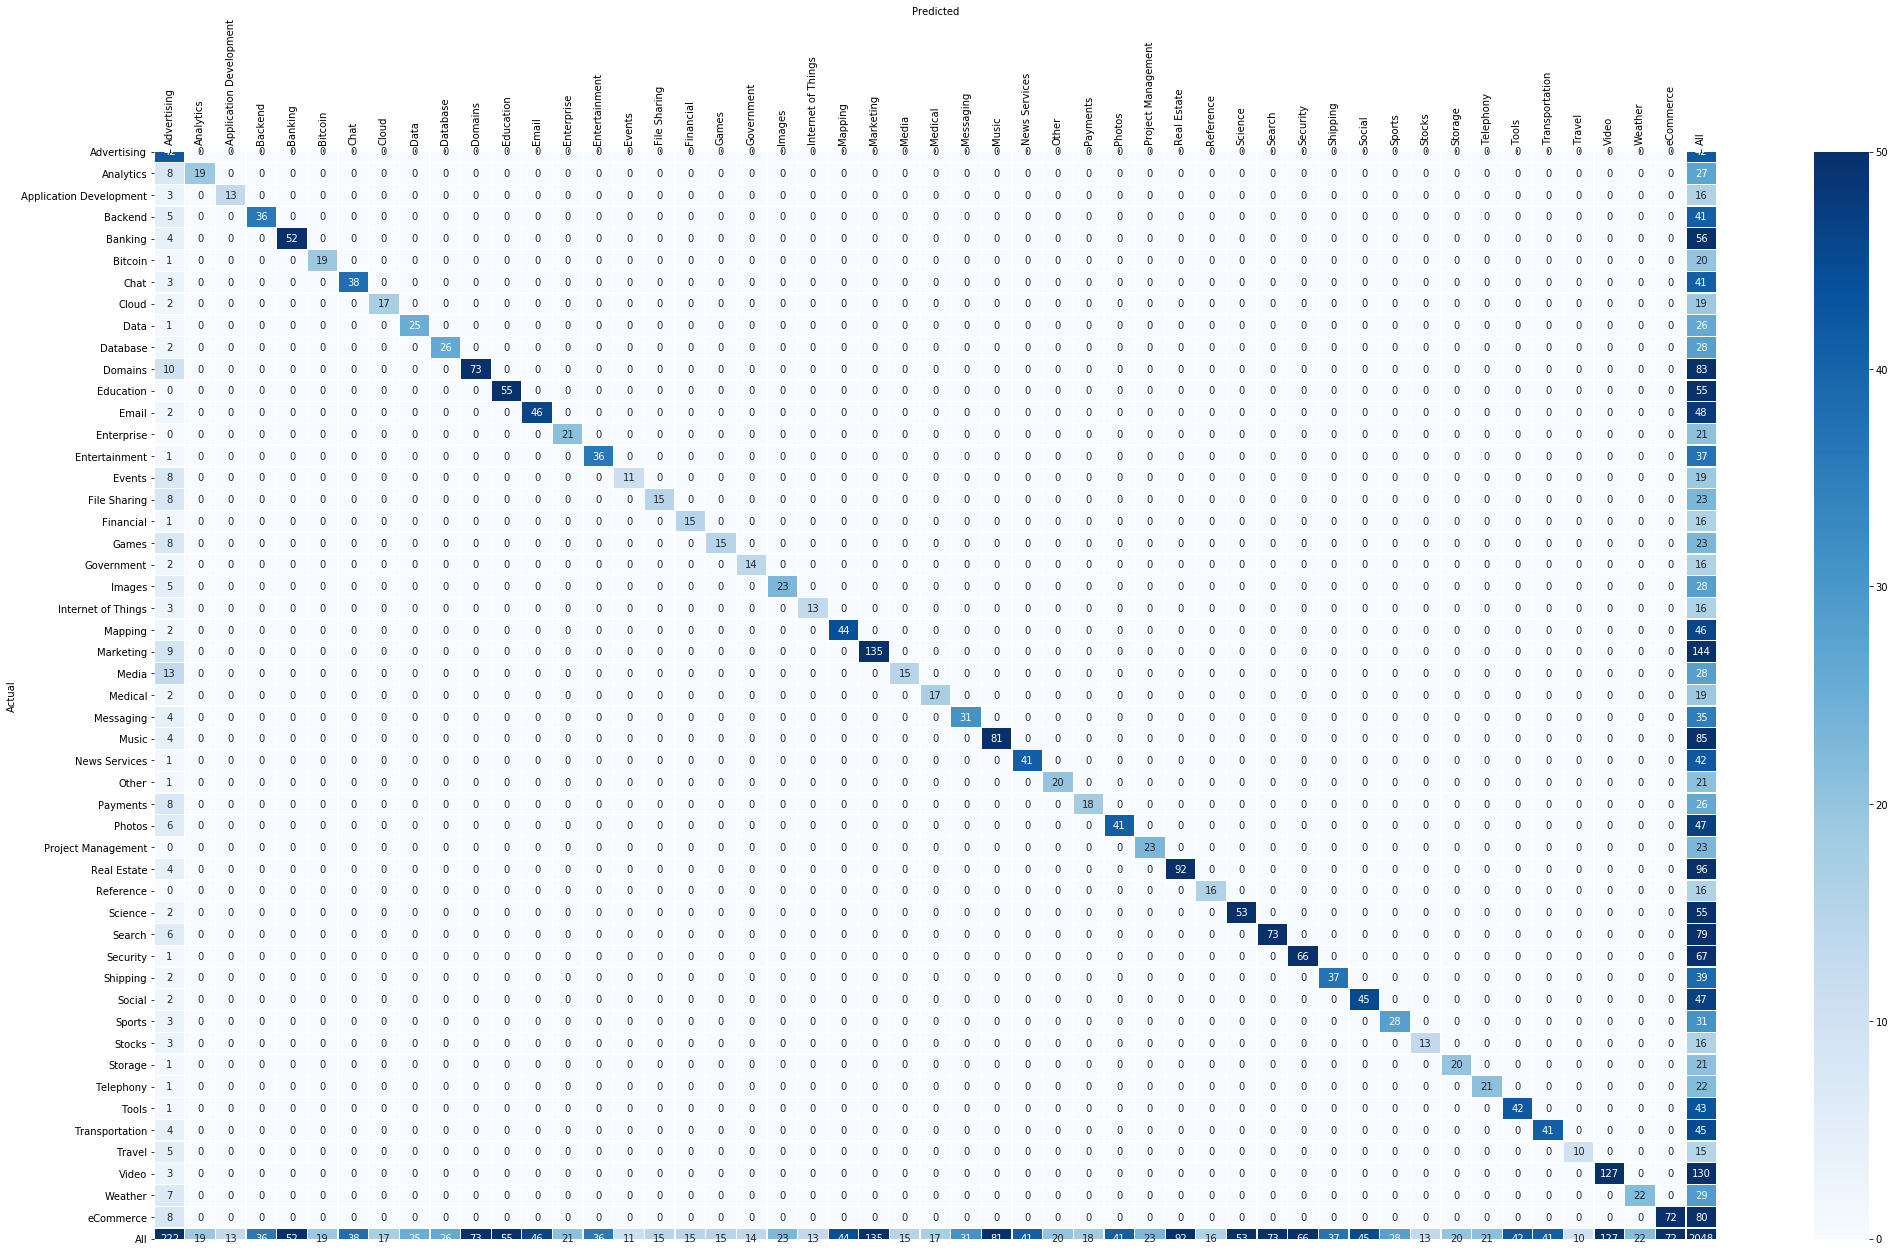

In [0]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('Top5-ServenetNewHeatMap.pdf', format='pdf', dpi=300)